# <center>+++ Project still in progres +++<center>

# Sentiment Analysis on Twitter Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
%%time
columns = ['target', 'id', 'date', 'query_string', 'user', 'text']
df = pd.read_csv('trainingdata.csv', header=None, names=columns, encoding='latin1')

Wall time: 4.95 s


In [3]:
df.head()

,target,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        
        try:
          doc = doc.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
          doc = souped
        
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
            
            pat1 = r'@[A-Za-z0-9_]+'
            pat2 = r'https?://[^ ]+'
            www_pat = r'www.[^ ]+'
            combined_pat = r'|'.join((pat1, pat2))
            doc = re.sub(combined_pat, '', doc)
            doc = re.sub(www_pat, '', doc)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [5]:
df.groupby(['target']).count()

,id,date,query_string,user,text
target,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


In [6]:
decode_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 744 ms


Text(0.5, 1.0, 'Dataset labels distribution')

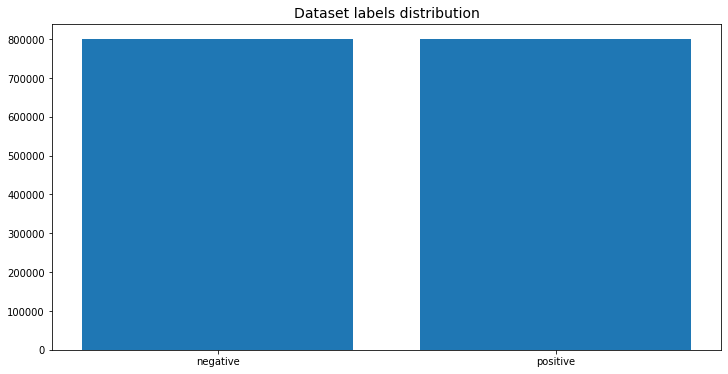

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(12,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset labels distribution', fontsize=14)

In [9]:
%%time
cvec = CountVectorizer()
cvec.fit(df.text)

Wall time: 39.4 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [10]:
print(cvec.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
neg_doc_matrix = cvec.transform(df[df.target == 'negative'].text)
pos_doc_matrix = cvec.transform(df[df.target == 'positive'].text)

neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos], columns=cvec.get_feature_names()).transpose()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df.sort_values(by='total', ascending=False).iloc[0:10]

,negative,positive,total
to,313176,252704,565880
the,257869,266003,523872
my,190846,125983,316829
it,157225,147544,304769
and,153968,149635,303603
you,103842,198194,302036
is,128452,109876,238328
in,115445,101115,216560
for,98986,117362,216348
of,92717,91087,183804


Text(0.5,1,'Top 50 tokens in negative tweets')

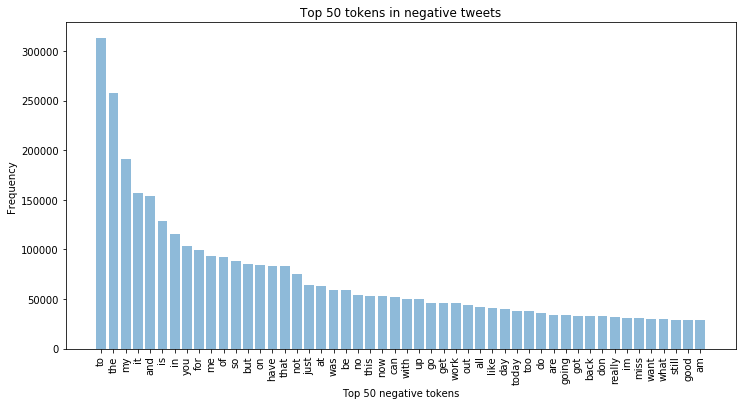

In [16]:
y_pos = np.arange(50)
plt.figure(figsize=(12,6))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Top 50 tokens in positive tweets')

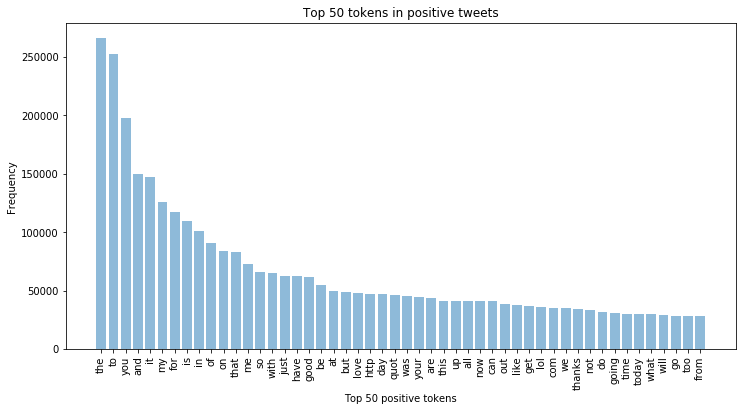

In [17]:
y_pos = np.arange(50)
plt.figure(figsize=(12,6))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

In [14]:
corpus = ['This is the first document.','This document is the second document.','And this is the third one.', 'Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
